# Simulations

We will generate synthetic signals. These synthetic signals are useful for testing and validating the procedures.

### Simulating the GradientTable

The first thing to do is to generate a set of diffusion acquisition parameters (diffusion gradient directions and respective b-values).

Let’s assume that we have to generate a different set of dMRI acquisition parameters. Let’s simulate signals for 60 directions for a b-value=1000 and a b-value=0 experiment.

Directions evenly sampling the 3D cartesian space can be generated using Dipy's "disperse_charges" function which is an implementation of electrostatic repulsion.

In [1]:
from dipy.core.sphere import disperse_charges, HemiSphere

import numpy for matrix manipulations

In [2]:
import numpy as np

Before running the "disperse_charges" algorithm, we need to generate some initial directions estimates. Here this is done by creating some random points on a HemiSphere using spherical polar coordinates.

In [3]:
n_pts = 60
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

Next, we call "disperse_charges" which will iteratively move the points so that the electrostatic potential energy is minimized (input 5000 indicates that this algorithm is performed for 5000 iterations).

In [4]:
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

In "hsph_updated" we have the updated HemiSphere with the points nicely distributed on the hemisphere. Below we'll visualize them.

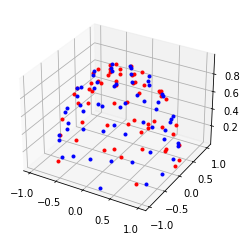

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(hsph_initial.vertices[:, 0], hsph_initial.vertices[:, 1], hsph_initial.vertices[:, 2], '.r')
ax.plot(hsph_updated.vertices[:, 0], hsph_updated.vertices[:, 1], hsph_updated.vertices[:, 2], '.b')

Now that we have the 60 directions simulated, let's create the GradientTable object:

In [6]:
from dipy.core.gradients import gradient_table

bvecs = np.vstack((np.array([0, 0, 0]), hsph_updated.vertices))
bvals = np.ones(n_pts + 1) * 1000
bvals[0] = 0;

gtab = gradient_table(bvals, bvecs)

### DTI in single tensor simulations

Let's consider a voxel fully described by a single tensor with axial diffusivity of 1.7e-3 $mm^2/ms$, radial diffusivity of 0.3e-3 $mm^2/ms$ and with main tensor direction with polar coordinates of $\theta=-45^o$ and $\phi=0^o$. 

Note: the values of diffusivities are typical values measured by DTI in well-aligned white matter regions of interest. The FA of this tensor is around 0.8.

In [7]:
from dipy.sims.voxel import _check_directions, all_tensor_evecs

from dipy.reconst.dti import fractional_anisotropy

AD_gt = 1.7e-3
RD_gt = 0.3e-3

# diffusion tensor main direction
angle = (-45.0, 0.0)
direction_gt = _check_directions([angle])

# Reconstruct the eigenvalues of the diffusion tensor
evals = np.array([AD_gt, RD_gt, RD_gt]);

# Sample eigenvectors from diffusion tensor main direction
evecs = all_tensor_evecs(direction_gt[0])

# Convert to 4D arrays since plotting functions require
evals4D = np.array([[[evals]]])
evecs4D = np.array([[[evecs]]])

# print the ground truth Fractional Anisotropy
print("Ground truth FA is {}".format(fractional_anisotropy(evals)))

Ground truth FA is 0.7990222037494894


Below we use fury to plot the diffusion tensor

In [8]:
from dipy.viz import window, actor
from dipy.data import get_sphere

# load 724 direction sampling the unit sphere for plotting 
sphere = get_sphere('repulsion724')

# Color of the tensor is defined according to tensor main direction
color4D = np.zeros(evals4D.shape)
color4D[0, 0, 0, :] = np.abs(direction_gt);  # color coded

# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='single_tensor_voxel_gt.png', size=(600, 600))

Now that we computed the ground truth tensor eigenvalues and eigenvectors, we'll generate the expected dMRI signals for this single tensor voxel and the acquisition parameters saved in gtab.

In [9]:
from dipy.sims.voxel import single_tensor

signal1 = single_tensor(gtab, S0=1, evals=evals, evecs=evecs, snr=None)

Let's now fit DTI model to these synthetic signals

In [10]:
from dipy.reconst.dti import TensorModel

dti_model = TensorModel(gtab)
dti_fit = dti_model.fit(signal1)

Plot the estimated diffusion tensor and its standard DTI metrics (MD, AD, RD, FA)

In [11]:
evals4D = np.array([[[dti_fit.evals]]])
evecs4D = np.array([[[dti_fit.evecs]]])

# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='single_tensor_voxel_fit.png', size=(600, 600))


print("MD = {} mm2/s".format(dti_fit.md))
print("AD = {} mm2/s".format(dti_fit.ad))
print("RD = {} mm2/s".format(dti_fit.rd))
print("FA = {}".format(dti_fit.fa))

MD = 0.0007666666666666669 mm2/s
AD = 0.0016999999999999988 mm2/s
RD = 0.00030000000000000084 mm2/s
FA = 0.7990222037494886


For these synthetic signals, we can see that the diffusion tensor retrieves values that matches it ground truth.

Now we'll plot the ODF estimated from the diffusion tensor

In [12]:
# transform our data from 1D to 4D
odf = dti_fit.odf(sphere)
odf4D = odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='odf_single_tensor.png', size=(600, 600))

### DTI in multi tensor simulations

Let’s consider a voxel containing two tensors with different orientations. This may be seen as a simplistic representation of two crossing fibres.

In [13]:
# diffusion tensor main direction
angle1 = (60.0, 0.0)
direction_gt1 = _check_directions([angle1])
angle2 = (0.0, 0.0)
direction_gt2 = _check_directions([angle2])

# Reconstruct the eigenvalues of the diffusion tensor
evals1 = [AD_gt, RD_gt, RD_gt];
evals2 = [AD_gt, RD_gt, RD_gt];

# Sample eigenvectors from diffusion tensor main direction
evecs1 = all_tensor_evecs(direction_gt1[0])
evecs2 = all_tensor_evecs(direction_gt2[0])

# Convert to 4D arrays since plotting functions require
evals4D = np.array([[[evals1, evals2]]])
evecs4D = np.array([[[evecs1, evecs2]]])

Plot the two crossing diffusion tensors:

In [14]:
# Color of the tensor is defined according to tensor main direction
color4D = np.zeros(evals4D.shape)
color4D[0, 0, 0, :] = np.abs(direction_gt1);  # color coded
color4D[0, 0, 1, :] = np.abs(direction_gt2);

# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=100)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='multi_tensor_voxel_gt.png', size=(600, 600))

Now let's generate the expected dMRI signals for a system comprising the sum of these two tensors voxel and the acquisition parameters saved in gtab. This can be performed by using the function "multi_tensor" from "dipy.sims.voxel".

In [15]:
from dipy.sims.voxel import multi_tensor

mevals = [evals1, evals2]
angles = [angle1, angle2]
S0 = 1
fractions = [50, 50]
signal2, st = multi_tensor(gtab, mevals, S0, angles, fractions, snr=None)

Let's now fit DTI model to these synthetic signals

In [16]:
dti_fit = dti_model.fit(signal2)

Note that DTI assumes that diffusion anisotropy is well described by a single tensor. Therefore, the DTI fitted to the signals of a system comprising crossing white matter fibres will represent the tissue by a single total diffusion tensor. Let's plot this total diffusion tensor.

In [20]:
evals4D = np.array([[[dti_fit.evals]]])
evecs4D = np.array([[[dti_fit.evecs]]])


# Plot tensor using tensor_slicer attribute of actor object
scene = window.Scene()
tensor_actor = actor.tensor_slicer(evals4D, evecs4D, scalar_colors=color4D, sphere=sphere, scale=1)
tensor_actor.display(y=0)
tensor_actor.RotateX(90)
scene.add(tensor_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='multi_tensor_voxel_fit.png', size=(600, 600))

Note that the main direction of the total diffusion tensor does not match the directions of any fibre population. Moreover, the fractional anisotropy of the total diffusion tensor is much lower than the individual tensors.

In [18]:
print("Ground truth FA is {} while estimated FA is {}".format(fractional_anisotropy(evals), dti_fit.fa))

Ground truth FA is 0.7990222037494894 while estimated FA is 0.5855890949962144


Directions of this crossing tensor system cannot be also resolved from DTI's ODF as shown below:

In [19]:
# transform our data from 1D to 4D
odf = dti_fit.odf(sphere)
odf4D = odf[None, None, None, :]

scene = window.Scene()
odf_actor = actor.odf_slicer(odf4D, sphere=sphere, colormap='plasma')
odf_actor.display(y=0)
odf_actor.RotateX(90)
scene.add(odf_actor)

window.show(scene)

window.record(scene, n_frames=1, out_path='odf_multi_tensor.png', size=(600, 600))